# Fruit-360 (V2) Exploratory Data Analysis


## 1. Libraries and notebook configuration


In [16]:
import os
import random
from pathlib import Path
from collections import Counter, defaultdict
import hashlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps

sns.set_theme(style="whitegrid")
np.random.seed(42)
random.seed(42)
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

BASE_DIR = Path(".")
OUTPUT_DIR = BASE_DIR / "report_assets"
FIG_DIR = OUTPUT_DIR / "figures"
TABLE_DIR = OUTPUT_DIR / "tables"
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)
SAVE_FIGS = False

## 2. Directory overview and dataset integrity

We inspect the folder structure, count classes/images, and scan for corrupted files and unexpected extensions. Class reporting below also includes a mapping from variety folders to general classes (e.g., all Apple variants -> Apple).

In [17]:
BASE_DIR = Path(".")
DATA_DIR = BASE_DIR / "dataset" / "fruit360"
TRAIN_DIR = DATA_DIR / "Training"
TEST_DIR = DATA_DIR / "Test"

assert TRAIN_DIR.exists() and TEST_DIR.exists(), "Dataset folders not found."

IMG_EXTS = {".jpg", ".jpeg", ".png"}

train_classes = sorted([p.name for p in TRAIN_DIR.iterdir() if p.is_dir()])
test_classes = sorted([p.name for p in TEST_DIR.iterdir() if p.is_dir()])

def generalize_label(label):
    return label.split(" ")[0] if label else label

train_general = sorted({generalize_label(c) for c in train_classes})
test_general = sorted({generalize_label(c) for c in test_classes})

print(f"Training classes (varieties): {len(train_classes)}")
print(f"Test classes (varieties): {len(test_classes)}")
print(f"Variety mismatch: {set(train_classes) ^ set(test_classes)}")

print(f"Training classes (general): {len(train_general)}")
print(f"Test classes (general): {len(test_general)}")
print(f"General mismatch: {set(train_general) ^ set(test_general)}")

train_files = [p for p in TRAIN_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS]
test_files = [p for p in TEST_DIR.rglob("*") if p.suffix.lower() in IMG_EXTS]

print(f"Training images: {len(train_files)}")
print(f"Test images: {len(test_files)}")

corrupted = []
for p in train_files + test_files:
    try:
        with Image.open(p) as img:
            img.verify()
    except Exception:
        corrupted.append(p)

print(f"Corrupted images: {len(corrupted)}")

Training classes (varieties): 250
Test classes (varieties): 250
Variety mismatch: set()
Training classes (general): 79
Test classes (general): 79
General mismatch: set()
Training images: 130344
Test images: 43442
Corrupted images: 0


## 3. Image indexing and metadata table

We build a metadata table with path, class, general class, split, size, channels, file size, and optional checksum.

In [18]:
USE_CHECKSUM = False
MAX_FILES = None

all_files = [(p, "train") for p in train_files] + [(p, "test") for p in test_files]
if MAX_FILES is not None and MAX_FILES < len(all_files):
    all_files = random.sample(all_files, MAX_FILES)

rows = []
for p, split in all_files:
    try:
        with Image.open(p) as img:
            width, height = img.size
            mode = img.mode
            channels = len(img.getbands())
    except Exception:
        width, height, mode, channels = None, None, None, None

    checksum = None
    if USE_CHECKSUM:
        with open(p, "rb") as f:
            checksum = hashlib.md5(f.read()).hexdigest()

    class_label = p.parent.name
    rows.append({
        "path": str(p),
        "split": split,
        "class": class_label,
        "class_general": generalize_label(class_label),
        "width": width,
        "height": height,
        "mode": mode,
        "channels": channels,
        "file_size_kb": p.stat().st_size / 1024.0,
        "checksum": checksum,
    })

meta_df = pd.DataFrame(rows)
print(meta_df.head())
print(meta_df[["mode", "channels"]].value_counts().head(10))

                                                path  split          class  \
0  dataset/fruit360/Training/Blackberrie 1/r1_66_...  train  Blackberrie 1   
1  dataset/fruit360/Training/Blackberrie 1/r1_76_...  train  Blackberrie 1   
2  dataset/fruit360/Training/Blackberrie 1/r1_245...  train  Blackberrie 1   
3  dataset/fruit360/Training/Blackberrie 1/r1_133...  train  Blackberrie 1   
4  dataset/fruit360/Training/Blackberrie 1/r0_185...  train  Blackberrie 1   

  class_general  width  height mode  channels  file_size_kb checksum  
0   Blackberrie    100     100  RGB         3      4.656250     None  
1   Blackberrie    100     100  RGB         3      4.883789     None  
2   Blackberrie    100     100  RGB         3      6.031250     None  
3   Blackberrie    100     100  RGB         3      8.423828     None  
4   Blackberrie    100     100  RGB         3      7.111328     None  
mode  channels
RGB   3           173786
Name: count, dtype: int64


## 4. Class distribution and imbalance

We compute per-class counts and imbalance metrics at the general-class level, then visualize the distribution.

In [19]:
counts = meta_df.groupby(["split", "class_general"]).size().reset_index(name="count")

train_counts = counts[counts["split"] == "train"].set_index("class_general")["count"]

imbalance = {
    "min": int(train_counts.min()),
    "max": int(train_counts.max()),
    "ratio_max_min": float(train_counts.max() / train_counts.min()),
    "p10": float(np.percentile(train_counts, 10)),
    "p90": float(np.percentile(train_counts, 90)),
}
imbalance

{'min': 151,
 'max': 16571,
 'ratio_max_min': 109.74172185430463,
 'p10': 447.8,
 'p90': 3292.0000000000023}

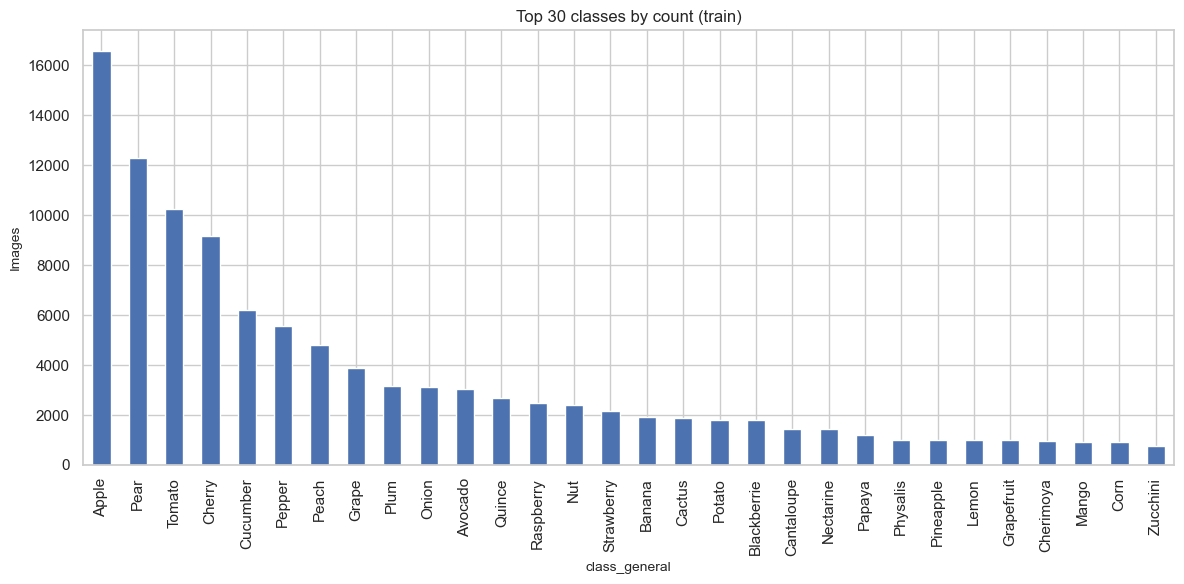

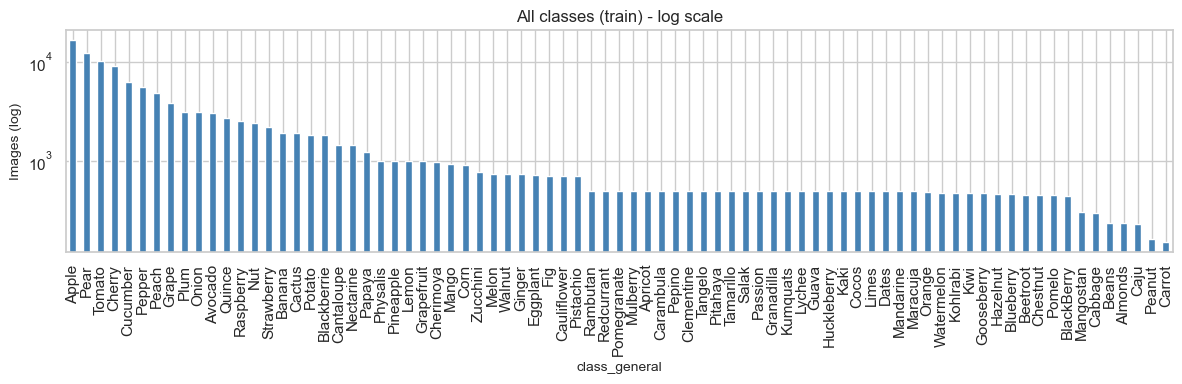

In [20]:
top_n = 30
train_sorted = train_counts.sort_values(ascending=False)
plt.figure(figsize=(12, 6))
train_sorted.head(top_n).plot(kind="bar")
plt.title(f"Top {top_n} classes by count (train)")
plt.ylabel("Images")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "class_counts_top.png", dpi=200)
plt.show()

plt.figure(figsize=(12, 4))
train_sorted.plot(kind="bar", color="steelblue")
plt.yscale("log")
plt.title("All classes (train) - log scale")
plt.ylabel("Images (log)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "class_counts_log.png", dpi=200)
plt.show()

## 5. Visual sampling of classes

Random grids for a quick look at within-class variability and global diversity, using general classes.

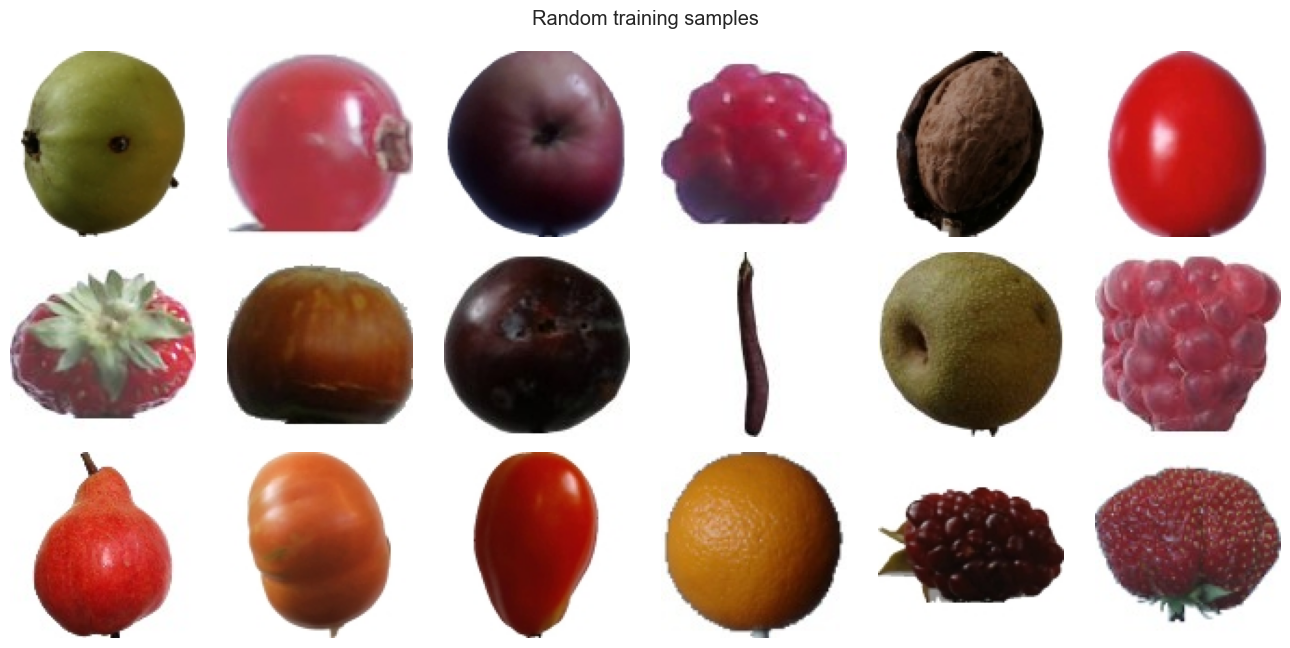

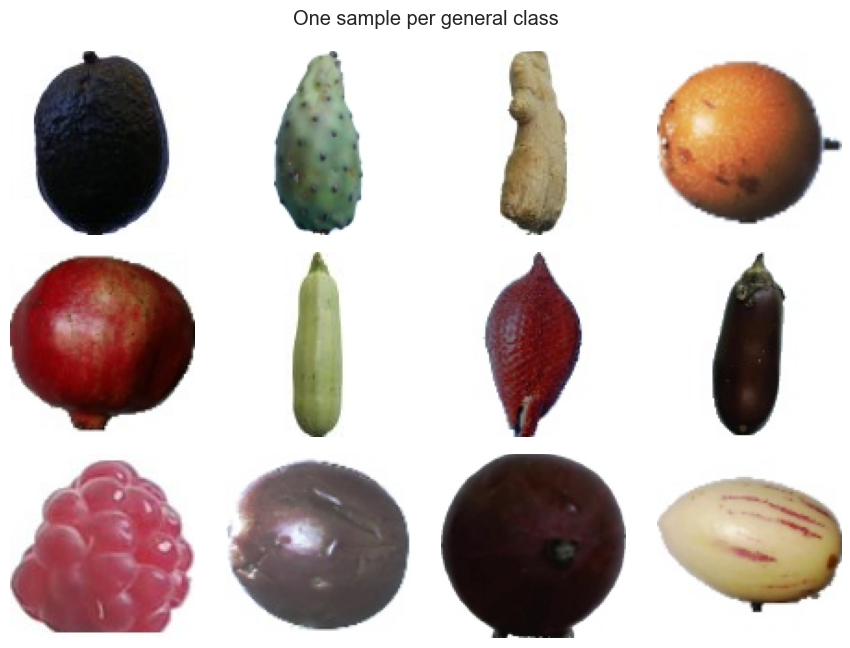

In [21]:
def show_image_grid(paths, nrows=3, ncols=6, title=None):
    plt.figure(figsize=(2.2 * ncols, 2.2 * nrows))
    for i, p in enumerate(paths[: nrows * ncols]):
        ax = plt.subplot(nrows, ncols, i + 1)
        img = Image.open(p)
        ax.imshow(img)
        ax.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

sample_paths = random.sample(train_files, 18)
show_image_grid(sample_paths, nrows=3, ncols=6, title="Random training samples")

multi_class_paths = []
general_classes = sorted(meta_df[meta_df["split"] == "train"]["class_general"].unique())
for cls in random.sample(general_classes, min(12, len(general_classes))):
    cls_paths = meta_df[(meta_df["split"] == "train") & (meta_df["class_general"] == cls)]["path"].tolist()
    if cls_paths:
        multi_class_paths.append(Path(random.choice(cls_paths)))
show_image_grid(multi_class_paths, nrows=3, ncols=4, title="One sample per general class")

## 6. RGB channel analysis

We compute per-image channel statistics to understand color dominance.

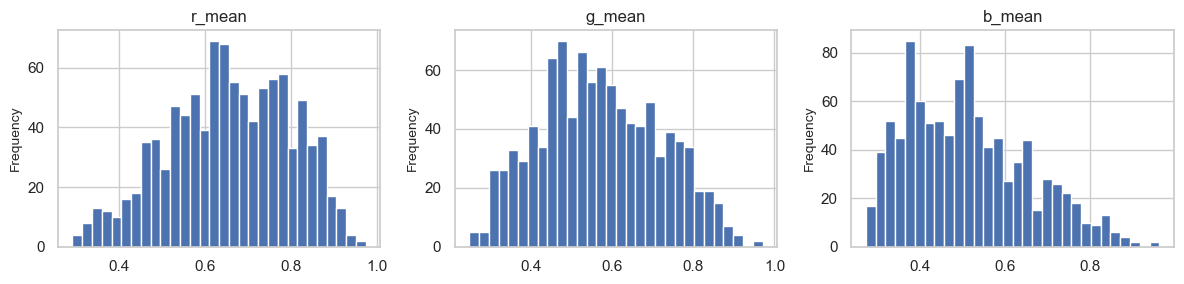

In [23]:
RGB_SAMPLE = 1000
sample_paths = random.sample(train_files, min(RGB_SAMPLE, len(train_files)))

rgb_stats = []
for p in sample_paths:
    img = Image.open(p).convert("RGB")
    arr = np.asarray(img) / 255.0
    means = arr.mean(axis=(0, 1))
    stds = arr.std(axis=(0, 1))
    rgb_stats.append({"r_mean": means[0], "g_mean": means[1], "b_mean": means[2],
                      "r_std": stds[0], "g_std": stds[1], "b_std": stds[2]})

rgb_df = pd.DataFrame(rgb_stats)

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for i, col in enumerate(["r_mean", "g_mean", "b_mean"]):
    rgb_df[col].plot(kind="hist", bins=30, ax=axes[i], title=col)
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "rgb_means_hist.png", dpi=200)
plt.show()

## 7. Duplicate and near-duplicate detection

We use perceptual hashing to identify potential duplicates and show examples.

Potential duplicate groups: 631


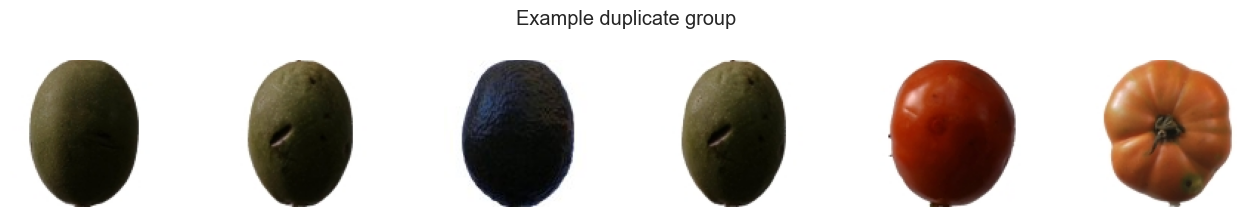

In [25]:
def ahash(img, hash_size=8):
    img = img.convert("L").resize((hash_size, hash_size))
    arr = np.asarray(img)
    return (arr > arr.mean()).astype(np.uint8).flatten()

def hash_to_int(bits):
    return int("".join(bits.astype(str)), 2)

HASH_SAMPLE_LIMIT = 5000
hash_paths = random.sample(train_files, min(HASH_SAMPLE_LIMIT, len(train_files)))

hash_map = defaultdict(list)
for p in hash_paths:
    img = Image.open(p)
    h = hash_to_int(ahash(img))
    hash_map[h].append(p)

duplicate_groups = [v for v in hash_map.values() if len(v) > 1]
print(f"Potential duplicate groups: {len(duplicate_groups)}")

if duplicate_groups:
    show_image_grid(duplicate_groups[0], nrows=1, ncols=min(6, len(duplicate_groups[0])), title="Example duplicate group")

## 8. Image quality: blur and noise

We estimate blur using Laplacian variance and a simple noise proxy on a sample.

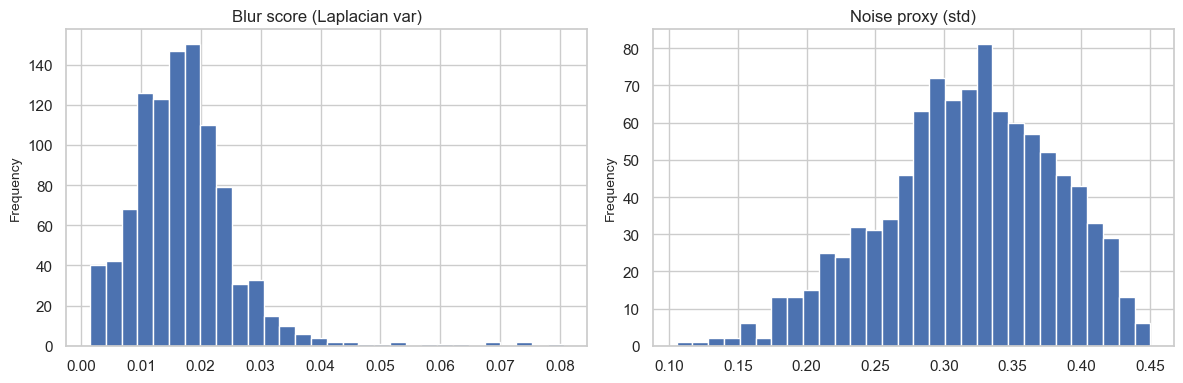

In [26]:
def laplacian_var(gray_arr):
    try:
        import cv2
        lap = cv2.Laplacian(gray_arr, cv2.CV_32F)
        return float(lap.var())
    except Exception:
        kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
        padded = np.pad(gray_arr, 1, mode="edge")
        h, w = gray_arr.shape
        lap = np.zeros_like(gray_arr, dtype=np.float32)
        for i in range(h):
            for j in range(w):
                window = padded[i:i+3, j:j+3]
                lap[i, j] = np.sum(window * kernel)
        return float(np.var(lap))

QUALITY_SAMPLE = 1000
quality_paths = random.sample(train_files, min(QUALITY_SAMPLE, len(train_files)))

qualities = []
for p in quality_paths:
    img = Image.open(p).convert("L")
    arr = np.asarray(img, dtype=np.float32) / 255.0
    blur_score = laplacian_var(arr)
    noise_score = float(np.std(arr - arr.mean()))
    qualities.append({"path": str(p), "blur_score": blur_score, "noise_score": noise_score})

quality_df = pd.DataFrame(qualities)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
quality_df["blur_score"].plot(kind="hist", bins=30, ax=axes[0], title="Blur score (Laplacian var)")
quality_df["noise_score"].plot(kind="hist", bins=30, ax=axes[1], title="Noise proxy (std)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "quality_metrics_hist.png", dpi=200)
plt.show()

## 9. Outliers and problematic cases

We surface anomalous sizes, non-RGB images, and low-quality samples for manual inspection.

Size outliers: 0
Non-RGB images: 0


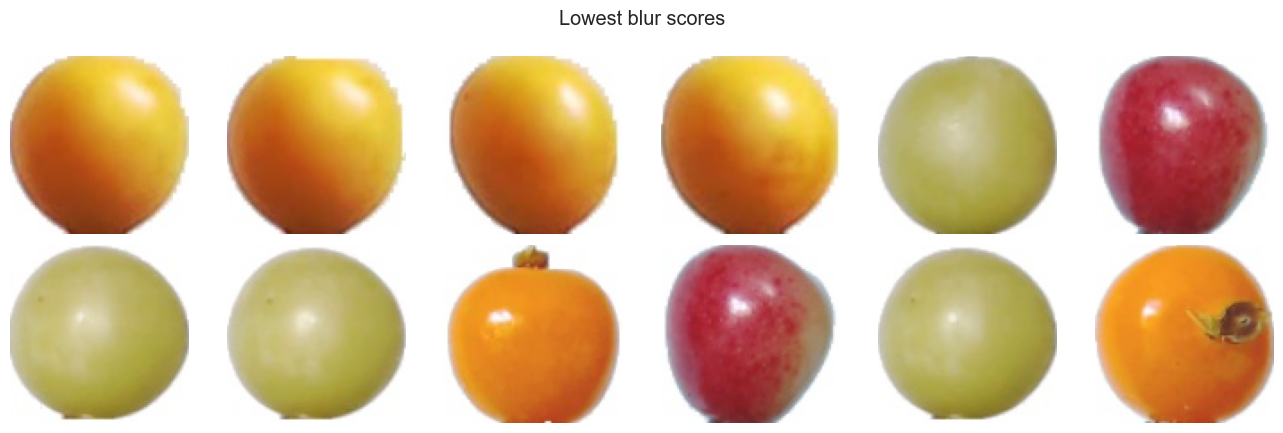

In [27]:
mode_w, mode_h = int(size_mode["width"]), int(size_mode["height"])
size_outliers = meta_df[(meta_df["width"] != mode_w) | (meta_df["height"] != mode_h)]
non_rgb = meta_df[meta_df["channels"] != 3]

print(f"Size outliers: {len(size_outliers)}")
print(f"Non-RGB images: {len(non_rgb)}")

low_blur = quality_df.nsmallest(12, "blur_score")
show_image_grid([Path(p) for p in low_blur["path"].tolist()], nrows=2, ncols=6, title="Lowest blur scores")

if len(size_outliers) > 0:
    show_image_grid([Path(p) for p in size_outliers["path"].head(12)], nrows=2, ncols=6, title="Size outliers")

## 10. Exploratory-only split (stratified)

We create a stratified split for descriptive analysis and compare distributions at the general-class level.

In [28]:
EDA_SPLIT = 0.8
train_meta = meta_df[meta_df["split"] == "train"].copy()

eda_rows = []
for cls, group in train_meta.groupby("class_general"):
    idx = group.index.tolist()
    random.shuffle(idx)
    cut = int(len(idx) * EDA_SPLIT)
    for i in idx[:cut]:
        eda_rows.append({"index": i, "eda_split": "eda_train"})
    for i in idx[cut:]:
        eda_rows.append({"index": i, "eda_split": "eda_val"})

eda_split_df = pd.DataFrame(eda_rows).set_index("index")
train_meta = train_meta.join(eda_split_df)

eda_counts = train_meta.groupby(["eda_split", "class_general"]).size().unstack(0).fillna(0)
eda_counts.head()

eda_split,eda_train,eda_val
class_general,,
Almonds,185,47
Apple,13256,3315
Apricot,393,99
Avocado,2448,612
Banana,1533,384


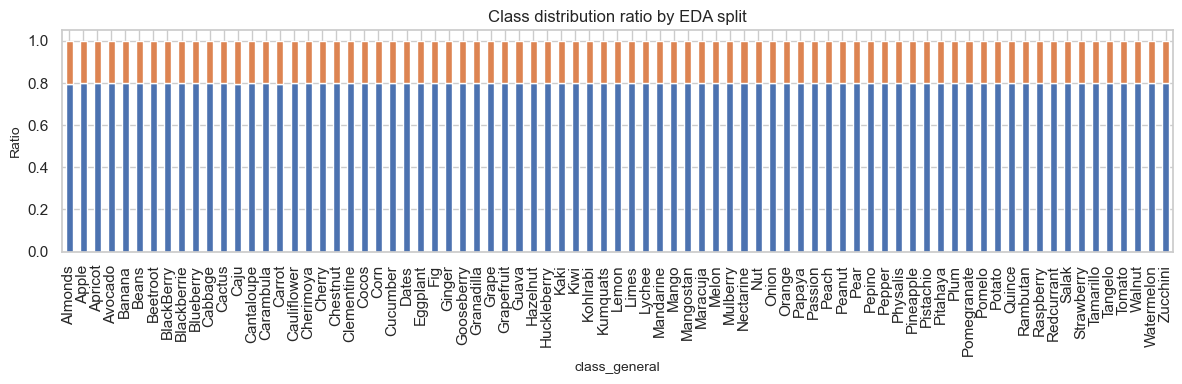

In [29]:
eda_counts_ratio = eda_counts.div(eda_counts.sum(axis=1), axis=0)
eda_counts_ratio.plot(kind="bar", stacked=True, figsize=(12, 4), legend=False)
plt.title("Class distribution ratio by EDA split")
plt.ylabel("Ratio")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "eda_split_distribution.png", dpi=200)
plt.show()